**This Notebook goes along with convnet_devp3.py. Compared to experiment2 notebook, it adds in L2 regularization on fully connected layers. It also adds a Batch Normlization layer after each CONV/FC layer**

In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from convnet_devp3 import *

/Users/Zhongyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Zhongyu/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Load Data

In [2]:
train_dataset, train_labels, test_dataset, test_labels = load_data()

Loading the training data...
Loading the testing data...


### Split Training and Validation Data

In [3]:
train_dataset, valid_dataset, train_labels, valid_labels = \
    train_test_split(train_dataset, train_labels, test_size=10000,\
    random_state=897, stratify=train_labels)

### Reshape Data - 32x32x3

In [4]:
train_dataset = np.rollaxis(train_dataset.reshape((-1,3,32,32)), 1, 4)
valid_dataset = np.rollaxis(valid_dataset.reshape((-1,3,32,32)), 1, 4)
test_dataset = np.rollaxis(test_dataset.reshape((-1,3,32,32)), 1, 4)
print 'Dataset\t\tFeatureShape\t\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape, '\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape		LabelShape
Training set:	(40000, 32, 32, 3) 	(40000,)
Validation set:	(10000, 32, 32, 3) 	(10000,)
Testing set:	(10000, 32, 32, 3) 	(10000,)


### Data Augmentation - 50% of training upside down flip; 50% mirror flip

In [5]:
# Dataset Parameters
image_size = 32
num_labels = 10
num_channels = 3
train_dataset, train_labels = preprocess_data(train_dataset, train_labels, num_labels)
valid_dataset, valid_labels = preprocess_data(valid_dataset, valid_labels, num_labels)
test_dataset,  test_labels  = preprocess_data(test_dataset,  test_labels,  num_labels)

### Generate a fixed small batch of data for corase tuning

In [6]:
train_batch_size = 32
valid_batch_size = 32
train_batch, train_label_batch = generate_batch(train_dataset, train_labels, train_batch_size)
valid_batch, valid_label_batch = generate_batch(valid_dataset, valid_labels, valid_batch_size)

### Setup Network Parameters

In [7]:
# Parameters for building blocks
kernel_size3 = 3
kernel_size5 = 5
num_filter = 64
fc_size1 = 512

In [8]:
# Setup shapes for each layer in the convnet
convnet_shapes = [['conv1', [kernel_size5, kernel_size5, num_channels, num_filter]],
                  ['conv2', [kernel_size3, kernel_size3, num_filter, num_filter]],
                  ['conv3', [kernel_size5, kernel_size5, num_filter, num_filter]],
                  ['fc1'  , [(image_size/2/2/2)**2*num_filter, fc_size1]],
                  ['fc2'  , [fc_size1, num_labels]]]

In [9]:
model = convnet_stack
epoch = 21

In [22]:
import convnet_devp3
reload(convnet_devp3)
from convnet_devp3 import batch_norm_layer
from convnet_devp3 import initialize_variables

In [196]:
hyperparams={'keep_prob': .42, 'init_lr': 0.004, 'decay_rate': .7, 'beta':.017,
             'initializer':tf.truncated_normal_initializer(stddev=0.33),#tf.contrib.layers.variance_scaling_initializer(4.),
             'batch_norm':True,
             'decay_steps':500, 'optimizer':tf.train.AdamOptimizer}

In [197]:
graph = tf.Graph()
with graph.as_default():
    tf_data = {'train_X': tf.constant(train_batch), 'train_y': tf.constant(train_label_batch),
               'valid_X': tf.constant(valid_batch), 'valid_y': tf.constant(valid_label_batch),
               'test_X' : None, 'test_y': None}

In [198]:
graph, training_data = train_convnet(graph, model, tf_data, convnet_shapes, hyperparams, epoch, False)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 2.499240	 Time cost: 1	Train Acc: 9.38%	Valid Acc: 16%	Learning rate: 0.004000
Epoch: 1:	 Loss: 1.930284	 Time cost: 1	Train Acc: 34.38%	Valid Acc: 12%	Learning rate: 0.004000
Epoch: 2:	 Loss: 1.522093	 Time cost: 1	Train Acc: 56.25%	Valid Acc: 12%	Learning rate: 0.004000
Epoch: 3:	 Loss: 1.486176	 Time cost: 1	Train Acc: 65.62%	Valid Acc:  9%	Learning rate: 0.004000
Epoch: 4:	 Loss: 1.300565	 Time cost: 1	Train Acc: 75.00%	Valid Acc:  9%	Learning rate: 0.004000
Epoch: 5:	 Loss: 1.177932	 Time cost: 1	Train Acc: 75.00%	Valid Acc:  9%	Learning rate: 0.004000
Epoch: 6:	 Loss: 1.093027	 Time cost: 1	Train Acc: 81.25%	Valid Acc:  9%	Learning rate: 0.004000
Epoch: 7:	 Loss: 1.018849	 Time cost: 1	Train Acc: 84.38%	Valid Acc:  9%	Learning rate: 0.004000
Epoch: 8:	 Loss: 0.971666	 Time cost: 1	Train Acc: 87.50%	Valid Acc:  9%	Learning rate: 0.004000
Epoch: 9

### Implement functions for random search - Log Space Search

In [57]:
def plot_data(data):
    epoch = range(data['train_losses'].shape[0])
    plt.subplot(211)
    plt.plot(epoch, data['train_losses'], label= 'training loss')
    plt.plot(epoch, data['valid_losses'], label='validation loss')
    plt.ylim([-.1,4])
    plt.legend(loc='upper right')
    plt.subplot(212)
    plt.plot(epoch, data['train_acc'], label='training accuracy')
    plt.plot(epoch, data['valid_acc'], label='validation accuracy')
    plt.ylim([0.0, 1.1])
    plt.legend(loc='upper right')
    plt.show()

In [55]:
def random_search(num_experiments, train_batch_size, valid_batch_size, convnet_shapes, epoch):
    experiment_data = {}
    for i in range(num_experiments):
        # Prepare small batch of data for experimental training
        train_batch, train_label_batch = generate_batch(train_dataset, train_labels, train_batch_size)
        valid_batch, valid_label_batch = generate_batch(valid_dataset, valid_labels, valid_batch_size)
        # Sample random HyperParameters
        hyperparams = generate_hyperparams()
        # Prepare data for tensorflow
        graph = tf.Graph()
        with graph.as_default():
            tf_data = {'train_X': tf.constant(train_batch), 'train_y': tf.constant(train_label_batch),
                       'valid_X': tf.constant(valid_batch), 'valid_y': tf.constant(valid_label_batch),
                       'test_X' : None, 'test_y': None}
        hyperparams['initializer'] = tf.truncated_normal_initializer(stddev=hyperparams['init_std'])
        # Train convnet
        model = convnet_stack
        _, training_data = train_convnet(graph, model, tf_data, convnet_shapes, hyperparams, epoch, False)
        key = (hyperparams['keep_prob'], hyperparams['init_lr'], hyperparams['init_std'], hyperparams['beta'])
        experiment_data[key] = training_data
        print "Finished experiment ", str(i)
        print "="*100
    return experiment_data

In [151]:
def generate_hyperparams():
    # Generate random hyperparameters Log Space
    keep_prob = np.random.uniform(0.3, 0.7)
    init_lr = 10**np.random.uniform(-3,-2)#np.random.uniform(0.0001, 0.0009)
    init_std = np.random.uniform(0.01, 0.6) #10**np.random.uniform(-3,-1)
    beta = 10**np.random.uniform(-3, -1) # original setting (-6, -1)
    hyperparams={'keep_prob': keep_prob, 'init_lr': init_lr, 'decay_rate': 1., 'decay_steps':1000,
                 'init_std': init_std, 'beta':beta, 'optimizer':tf.train.AdamOptimizer, 'batch_norm':True}
    return hyperparams

### Random Search Through Hyperparameter Space

In [154]:
num_exp = 1
train_batch_size = 128
valid_batch_size = 32
epoch = 21

***
**Good Experiment Record 1**

In [155]:
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 2.497043	 Time cost: 2	Train Acc: 11.72%	Valid Acc:  9%	Learning rate: 0.006907
Epoch: 1:	 Loss: 2.200414	 Time cost: 2	Train Acc: 22.66%	Valid Acc:  6%	Learning rate: 0.006907
Epoch: 2:	 Loss: 1.866440	 Time cost: 2	Train Acc: 41.41%	Valid Acc:  6%	Learning rate: 0.006907
Epoch: 3:	 Loss: 1.648761	 Time cost: 2	Train Acc: 55.47%	Valid Acc: 12%	Learning rate: 0.006907
Epoch: 4:	 Loss: 1.492070	 Time cost: 2	Train Acc: 64.84%	Valid Acc: 16%	Learning rate: 0.006907
Epoch: 5:	 Loss: 1.411582	 Time cost: 2	Train Acc: 63.28%	Valid Acc: 16%	Learning rate: 0.006907
Epoch: 6:	 Loss: 1.254028	 Time cost: 2	Train Acc: 76.56%	Valid Acc: 12%	Learning rate: 0.006907
Epoch: 7:	 Loss: 1.164590	 Time cost: 2	Train Acc: 80.47%	Valid Acc: 12%	Learning rate: 0.006907
Epoch: 8:	 Loss: 1.043790	 Time cost: 2	Train Acc: 85.94%	Valid Acc: 12%	Learning rate: 0.006907
Epoch: 

In [156]:
key = experiment_data.keys()[0]
exp_data = experiment_data[key]
print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'beta\t\t\t', 'valid accuracy'
print key[0],'\t\t',key[1],'\t',key[2],'\t\t',key[3],'\t', exp_data['valid_acc'][-1]

keep_prob		learning rate		init_std		beta			valid accuracy
0.44213032087 		0.00690662918828 	0.521996460027 		0.0282275615654 	0.15625


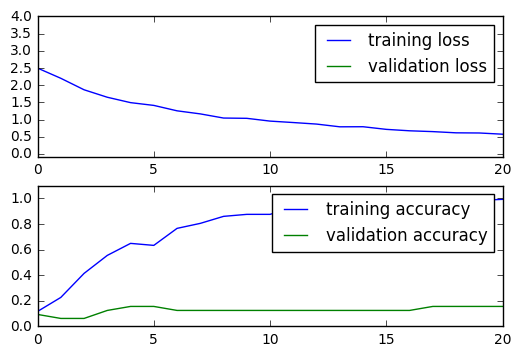

In [157]:
plot_data(exp_data)

***
**Good Experiment Record 2**

In [166]:
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 2.468071	 Time cost: 2	Train Acc: 9.38%	Valid Acc: 12%	Learning rate: 0.001115
Epoch: 1:	 Loss: 2.391333	 Time cost: 2	Train Acc: 9.38%	Valid Acc:  9%	Learning rate: 0.001115
Epoch: 2:	 Loss: 2.354904	 Time cost: 2	Train Acc: 14.06%	Valid Acc:  9%	Learning rate: 0.001115
Epoch: 3:	 Loss: 2.237288	 Time cost: 2	Train Acc: 20.31%	Valid Acc: 12%	Learning rate: 0.001115
Epoch: 4:	 Loss: 2.108455	 Time cost: 2	Train Acc: 25.78%	Valid Acc: 12%	Learning rate: 0.001115
Epoch: 5:	 Loss: 2.035473	 Time cost: 2	Train Acc: 28.12%	Valid Acc: 12%	Learning rate: 0.001115
Epoch: 6:	 Loss: 1.855656	 Time cost: 2	Train Acc: 43.75%	Valid Acc: 12%	Learning rate: 0.001115
Epoch: 7:	 Loss: 1.877129	 Time cost: 2	Train Acc: 36.72%	Valid Acc: 12%	Learning rate: 0.001115
Epoch: 8:	 Loss: 1.770058	 Time cost: 2	Train Acc: 44.53%	Valid Acc: 12%	Learning rate: 0.001115
Epoch: 9:

In [168]:
key = experiment_data.keys()[0]
exp_data = experiment_data[key]
print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'beta\t\t\t', 'valid accuracy'
print key[0],'\t\t',key[1],'\t',key[2],'\t\t',key[3],'\t', exp_data['valid_acc'][-1]

keep_prob		learning rate		init_std		beta			valid accuracy
0.422316283373 		0.00111459287908 	0.375999623514 		0.00163063092047 	0.3125


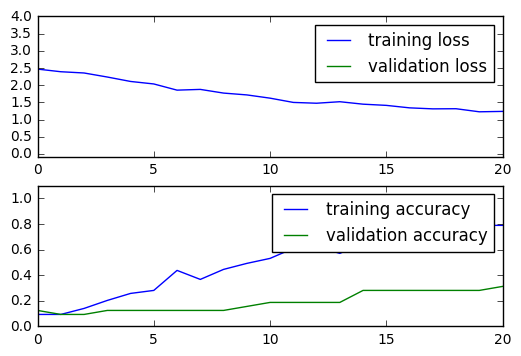

In [169]:
plot_data(exp_data)

***
**Good Experiment Record 3**

In [199]:
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 2.488609	 Time cost: 2	Train Acc: 4.69%	Valid Acc: 12%	Learning rate: 0.002012
Epoch: 1:	 Loss: 2.173756	 Time cost: 2	Train Acc: 21.09%	Valid Acc:  9%	Learning rate: 0.002012
Epoch: 2:	 Loss: 2.012465	 Time cost: 2	Train Acc: 32.03%	Valid Acc: 19%	Learning rate: 0.002012
Epoch: 3:	 Loss: 1.781718	 Time cost: 2	Train Acc: 41.41%	Valid Acc: 19%	Learning rate: 0.002012
Epoch: 4:	 Loss: 1.738168	 Time cost: 2	Train Acc: 50.00%	Valid Acc: 16%	Learning rate: 0.002012
Epoch: 5:	 Loss: 1.547821	 Time cost: 2	Train Acc: 57.03%	Valid Acc: 16%	Learning rate: 0.002012
Epoch: 6:	 Loss: 1.426891	 Time cost: 2	Train Acc: 63.28%	Valid Acc: 16%	Learning rate: 0.002012
Epoch: 7:	 Loss: 1.341481	 Time cost: 2	Train Acc: 70.31%	Valid Acc: 16%	Learning rate: 0.002012
Epoch: 8:	 Loss: 1.255644	 Time cost: 2	Train Acc: 74.22%	Valid Acc: 19%	Learning rate: 0.002012
Epoch: 9

In [203]:
key = experiment_data.keys()[0]
exp_data = experiment_data[key]
print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'beta\t\t\t', 'valid accuracy'
print key[0],'\t\t',key[1],'\t',key[2],'\t\t',key[3],'\t', exp_data['valid_acc'][-1]

keep_prob		learning rate		init_std		beta			valid accuracy
0.598524864182 		0.00201166627089 	0.394541091282 		0.0958682416236 	0.28125


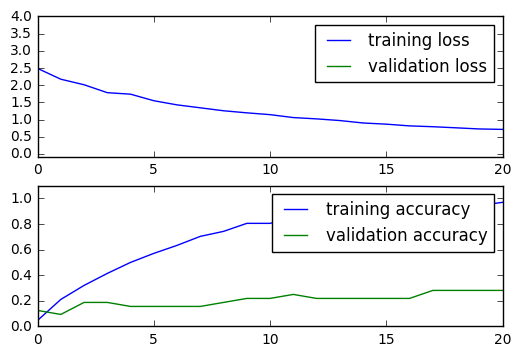

In [201]:
plot_data(exp_data)

***
### Summary
- Trail run parameters:
    - AdamOptimizer
    - Drop out keep prob: 0.47
    - Weights initialization: truncated_normal with stddev=0.33
    - Biases initialization : constant (1.0)
    - CONVNET architecture:
        * conv1: filter size 5x5, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool1: filter size 2x2, max pooling, stride=2, padding=SAME
        * conv2: filter size 3x3, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool2: filter size 2x2, max pooling, stride=2, padding=SAME
        * conv3: filter size 5x5, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool3: filter size 2x2, max pooling, stride=1, padding=SAME
        * fc1  : 512 neurons
        * fc2  : 10 neurons
    - Time cost per epoch:  secs
    - MiniBatch size: 512
    - Total epoches ran: 1164
    - learning rate: 0.0004, decay rate: 0.9, decay steps: 77, staircase: True
    - L2 regularization factor beta: 0.096